# Frequency of close Pairs

For a simulated source with a Crab-like sprectrum y with different input fluxes (from 1E-4 mCrab to 1 Crab), this script will plot:

    a) Undetected fractions of photons with A1 (threshold detection) and AD (Adjusted Derivative) methods vs input flux
    b) Undetected fractions of photons, not spotted by the derivative value (no detection, no flagging) vs input flux
    

## Initialization

Clean environment, load libraries/functions and set working directory

In [29]:
rm(list=ls())
library(FITSio)
library(Hmisc)
source("~/R/Rfunctions/drawLogPlotBox.r")
setwd("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/baselineLPA2")

Initialize variables: energies, fluxes, filters, legend_info

In [30]:
samprate <- 156250              # Hz-1 - sampling rate
XT <- ""                        # crosstalk string for filenames (set/unset crosstalk)
calibEnergies <- c("0.2","0.5","1","2","3","4","5","6","7","8") 
nen <- length(calibEnergies)    # number of primary Energies
# Input source fluxes in mCrab units (1 mCrab=2.1147E-11 erg/cm2/s 2-10kev)
fluxes.mcrab <- c("0.0001","0.0005","0.001","0.005","0.01","0.036","0.13","0.46",
                  "0.60","0.80","1.67","6.","21.54","77.43","278.26","1000.")
nFluxes <- length(fluxes.mcrab) # number of fluxes
filters <- c("_filter_", "_")   # Be Filter & w/o filter in response matrix
nfilters <- length(filters)
legendTitles<-c("Be Filter","NO Be Filter")
legendPos <- c("topright","right")
legendPch <- c(4,1)
#pdf(paste("e2e/FrequencyPairs",XT,".pdf",sep=""),width=10, height=7,version="1.4")

Define the areas where bagplots of paired pulses and single pulses coincide (indistinguishable), as a function of secondary pulses energy. Based on lots at Esec=0.2keV, Esec=1keV, Esec=4keV

In [31]:
BP.failRange <- list("0.2"=c(200,300),"0.5"=c(200,300), 
                     "1"=c(240,260), "2"=c(240,260),"3"=c(240,260),
                     "4"=c(235,245),"5"=c(235,245),"6"=c(235,245), "7"=c(235,245),"8"=c(235,245))


Define limiting values for detection in A1 and AD for low threshold (**lt**; just below the first sample of the derivative in 0.2 keV pulses) and high threshold (**ht**; just below the second sample of the derivative in 0.2 keV pulses). A1 results come from observation of threshold crossing (no yet implemented in SIRENA).

Lists give the minimum separation where methods would detect 90% of the pulses for different primary energies. 

In [32]:
# Secondaries are 0.2 keV: worse deetction, used as worst case
minSampAD_lt_02 <- list("0.2"=45,  "0.5"=5,   "1"=5,   "2"=5,   "3"=5,   "4"=5,   "5"=5,   "6"=5,   "7"=5,   "8"=5)
minSampAD_ht_02 <- list("0.2"=45,  "0.5"=5,   "1"=5,   "2"=5,   "3"=100, "4"=200, "5"=200, "6"=200, "7"=200, "8"=200) 
minSampA1_lt_02 <- list("0.2"=20,  "0.5"=45,  "1"=200, "2"=200, "3"=250, "4"=250, "5"=300, "6"=300, "7"=400, "8"=400)
minSampA1_ht_02 <- list("0.2"=200, "0.5"=250, "1"=300, "2"=400, "3"=400, "4"=400, "5"=800, "6"=800, "7"=800, "8"=800)
# Secondaries are 1 keV: better detection, not used
minSampAD_lt_1 <-  list("0.2"=60, "0.5"=20, "1"=5,  "2"=5,  "3"=5,  "4"=5,  "5"=5,  "6"=5,  "7"=5,  "8"=5) 
minSampAD_ht_1 <-  list("0.2"=60, "0.5"=20, "1"=5,  "2"=5,  "3"=5,  "4"=5,  "5"=5,  "6"=5,  "7"=5,  "8"=5) 
minSampA1_lt_1 <-  list("0.2"=45, "0.5"=45, "1"=45, "2"=45, "3"=45, "4"=45, "5"=45, "6"=45, "7"=45, "8"=45)
minSampA1_ht_1 <-  list("0.2"=5,  "0.5"=10, "1"=20, "2"=20, "3"=20, "4"=20, "5"=20, "6"=20, "7"=20, "8"=200)


Initialize variables. Results are the *percentage of events missed by A1/AD with low/high threshold* and the *percentage of events missed by A1/AD with low/high threshold and NOT flagged by bagplots*:

In [33]:
EkeVrecons <- numeric()  # reconstructed energy
evt.times  <- numeric()  # arrival time of events
evt.phids  <- numeric()  # PH_ID of events in event file
evt.pixids <- numeric()  # PIXID of events
pix.phids  <- numeric()  # PH_ID of events in piximpact file

# percentage of events missed by A1/AD with low/high threshold
percent.AD_lt <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.AD_ht <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.A1_lt <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.A1_ht <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
# percentage of events missed by A1/AD with low/high threshold and NOT flagged by bagplots
percent.BPAD_lt <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.BPAD_ht <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.BPA1_lt <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
percent.BPA1_ht <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))
# conservative approach: conflictive bagplot area is that of 0.2 keV secondaries and between 200-300 samples (does
# not take into account the reduction in the area for larger secondaries)
percent.BPA1_ht_cnsrv <- matrix(nrow=nFluxes,ncol = nfilters, dimnames=list(rep("",nFluxes), c("BeFilter", "NoFilter")))


## Seeking missing photons

For every photon (sedondary) it will look for the previous one (primary) and determine its separation. If this separation is lower than the minimum distance where every method (A1 and AD) has a detection success of 90%, both photons are considered "affected". -> left plot
In a second step, the flagging is analysed: if photons separation is in the range where the bagplots (single and pairs) overlap, pair could be confused with a single pair, thus rejection would not wok here. Photons are considered "affected" both at *detection* and at *flagging* stages -> right plot

Detection is evaluated for the *low* (lt) and *high* (ht) thresholds.

For Fluxes < 0.5 mCrab, XIFU will work "in-focus" and for larger fluxes "defocused" (35 mm). For large fluxes Be filter (that removes photons < 2keV) can/cannot be used. Input files have been simulated under all these conditions.

In [34]:
for (ifi in 1:nfilters){ 
    filter <- filters[ifi] # 'Be Filter' (_filter_)  or 'No Be Filter' (_)
    for (i in 1:nFluxes){
        if(fluxes.mcrab[i] < 0.5) { # in focus
            evtFile <- paste("e2e/crabSpec",fluxes.mcrab[i],"mCrab",XT,".fits",sep="")
            pixFile <- paste("e2e/crabSpec",fluxes.mcrab[i],"mCrab",XT,".piximpact",sep="")
        }else{ # defocused
            evtFile <- paste("e2e/crabSpec",fluxes.mcrab[i],"mCrab",filter,"35mm",XT,".fits",sep="")
            pixFile <- paste("e2e/crabSpec",fluxes.mcrab[i],"mCrab",filter,"35mm",XT,".piximpact",sep="")
        }
    
        cat("Working with ", evtFile,"\n")
        # open EVT file and read extensions
        zz <- file(description = evtFile, open = "rb")
        header0 <- readFITSheader(zz, fixHdr = 'remove') # read primary header
        header <- readFITSheader(zz, fixHdr = 'remove') # read extension header
        zz.hdr <- parseHdr(header)
        evtTable <- readFITSbintable(zz, header)
        close(zz)
        
        # read simulated & triggered events
        nsims <-as.numeric(zz.hdr[which(zz.hdr=="NESTOT")+1])
        ntrigs <- as.numeric(zz.hdr[which(zz.hdr=="NIMP")+1])
        idcol <- which(evtTable$colNames == "SIGNAL")
        EkeVrecons <- evtTable$col[[idcol]][1:ntrigs]  # reconstructed energies
        idcol <- which(evtTable$colNames == "TIME")
        evt.times <- evtTable$col[[idcol]][1:ntrigs]   # arrival times of triggered events
        idcol <- which(evtTable$colNames == "PH_ID")
        evt.phids <- evtTable$col[[idcol]][1:ntrigs]   # PH_ID of triggered events
        idcol <- which(evtTable$colNames == "PIXID")
        evt.pixids <- evtTable$col[[idcol]][1:ntrigs]  # PIXID of triggered events

        # If any of the photons have a reconsructed energy of 0.0 (xifupipeline has identified them 
        # as being piled-up or invalid), read the piximpact file (to get their original energy later)
        if(any(EkeVrecons == 0.0)){
            cat("   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons\n")
            pp <- file(description = pixFile, open = "rb")
            header0 <- readFITSheader(pp, fixHdr = 'remove') # read primary header
            header <- readFITSheader(pp, fixHdr = 'remove') # read extension header
            pp.hdr <- parseHdr(header)
            evtTable <- readFITSbintable(pp, header)
            close(pp)
            idcol <- which(evtTable$colNames == "ENERGY")
            EkeVsim <- evtTable$col[[idcol]][1:nsims] # simulated energy of event
            idcol <- which(evtTable$colNames == "PH_ID") # PH_ID of event
            pix.phids <- evtTable$col[[idcol]][1:nsims]
        }
        cat("   Photons (nsims=",nsims,"ntrigs=",ntrigs,")\n")

        # Initialize variables to get the IDs of the photons missed by A1/AD (too close to its primary)...
        missedAD_lt_ids <- numeric()
        missedAD_ht_ids <- numeric()
        missedA1_lt_ids <- numeric()
        missedA1_ht_ids <- numeric()
        #...and those missed and not flagged by bagplots approach (in overlapping area)
        BPAD_lt_ids <- numeric()
        BPAD_ht_ids <- numeric()
        BPA1_lt_ids <- numeric()
        BPA1_ht_ids <- numeric()
        BPA1_ht_cnsrv_ids <- numeric() 
        
        # For each photon (secondary candidate), gets its energy and the closest energy in calibration list
        # For the previous photon (primary candidate), gets its energy and the closest energy in calibration list
        for (ip in 1:ntrigs){
            # save simulated energy instead of 0.00 energy
            if(EkeVrecons[ip] == 0.0) EkeVrecons[ip] <- EkeVsim[pix.phids == evt.phids[ip]]
            if(ip==1) next
            BPfails <- FALSE
            BPfailsConserv <- FALSE
            # get distance with previous (in samples)
            diffSamples <- (evt.times[ip]-evt.times[ip-1])*samprate
            
            # look for the closest energy of photons Prim & Sec in calib list
            idclosPrim <- whichClosest(calibEnergies,EkeVrecons[ip-1])
            closestEnergyPrim <- calibEnergies[idclosPrim]
            idclosSec <- whichClosest(calibEnergies,EkeVrecons[ip])
            closestEnergySec <- calibEnergies[idclosSec]
        
            # If Primary <-> Secondary distance is lower than failure area in bagplots 
            #    (depending on Sec energy) and both are in the same pixel => 
            #     set flagging failure = TRUE
            #    Conservative approach will use only the range for first (0.2keV) secondaries (largest)
            #==========================================================================
            if((diffSamples>=BP.failRange[[closestEnergySec]][1] && diffSamples<=BP.failRange[[closestEnergySec]][2]))
                BPfails <- TRUE
            if((diffSamples>=BP.failRange[[calibEnergies[1]]][1] && diffSamples<=BP.failRange[[calibEnergies[1]]][2]))
                BPfailsConserv <- TRUE
              
            # AD detection
            # If Primary <-> Secondary distance is lower than minimum detection distance and
            #    both are in the same pixel => missed photons (Prim & Sec)
            # missedAD_lw/ht: Pulses missed by AD using lower and higher threshold 
            #    If secondaries are in [0.2-1)keV, use minSampAD_lt/ht_02
            #    If secondaries are in [1-8]keV, use minSampAD_lt/ht_1
            # If flagging failure=TRUE, add photons to the list of missing/noflagging photons
            #=================================================================================
            if(EkeVrecons[ip]<1.){ #secondary in [0.2-1)keV range
                if(diffSamples<minSampAD_lt_02[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedAD_lt_ids <- append(missedAD_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    # missing and no flagging
                    if(BPfails)  BPAD_lt_ids <- append(BPAD_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
                if(diffSamples<minSampAD_ht_02[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedAD_ht_ids <- append(missedAD_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    #cat("Missed AD_ht for ip=",ip,"-- Diff=",diffSamples,"\n")
                    # missing and no flagging
                    if(BPfails)  BPAD_ht_ids <- append(BPAD_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
            }else{ #secondary in [1-8]keV range
                if(diffSamples<minSampAD_lt_1[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedAD_lt_ids <- append(missedAD_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    if(BPfails)  BPAD_lt_ids <- append(BPAD_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
                if(diffSamples<minSampAD_ht_1[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedAD_ht_ids <- append(missedAD_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    #cat("Missed AD_ht for ip=",ip,"-- Diff=",diffSamples,"\n")
                    if(BPfails)  BPAD_ht_ids <- append(BPAD_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
            }
            # A1 detection
            # If Primary <-> Secondary distance is lower than minimum detection distance and
            #    both are in the same pixel => missed photons (Prim & Sec)
            # missedA1_lw/ht: Pulses missed by A1 using lower and higher threshold 
            #    If secondaries are in [0.2-1)keV, use minSampA1_lt/ht_02
            #    If secondaries are in [1-8]keV, use minSampA1_lt/ht_1
            # If flagging failure=TRUE, add photons to the list of missing/noflagging photons
            #=================================================================================       
            if(EkeVrecons[ip]<1.){ #secondary
                if(diffSamples<minSampA1_lt_02[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedA1_lt_ids <- append(missedA1_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    if(BPfails)  BPA1_lt_ids <- append(BPA1_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
                if(diffSamples<minSampA1_ht_02[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedA1_ht_ids <- append(missedA1_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))    
                    if(BPfails)  BPA1_ht_ids <- append(BPA1_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    if(BPfailsConserv)  BPA1_ht_cnsrv_ids <- append(BPA1_ht_cnsrv_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
            }else{
                if(diffSamples<minSampA1_lt_1[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedA1_lt_ids <- append(missedA1_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    if(BPfails)  BPA1_lt_ids <- append(BPA1_lt_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
                if(diffSamples<minSampA1_ht_1[[closestEnergyPrim]] && (evt.pixids[ip]==evt.pixids[ip-1])){
                    missedA1_ht_ids <- append(missedA1_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))    
                    if(BPfails)  BPA1_ht_ids <- append(BPA1_ht_ids, c(evt.phids[ip],evt.phids[ip-1]))
                    if(BPfailsConserv)  BPA1_ht_cnsrv_ids <- append(BPA1_ht_cnsrv_ids, c(evt.phids[ip],evt.phids[ip-1]))
                }
            }        
        } # trig photons
        cat("   percentages calculation\n")
        # percentage of photons missed by AD/A1 and out-of-scope of BP
        percent.BPA1_lt[i,ifi] <- 100*length(unique(BPA1_lt_ids))/nsims # % fraction of affected photons
        percent.BPA1_ht[i,ifi] <- 100*length(unique(BPA1_ht_ids))/nsims # % fraction of affected photons
        percent.BPA1_ht_cnsrv[i,ifi] <- 100*length(unique(BPA1_ht_cnsrv_ids))/nsims # % fraction of affected photons
        percent.BPAD_lt[i,ifi] <- 100*length(unique(BPAD_lt_ids))/nsims # % fraction of affected photons
        percent.BPAD_ht[i,ifi] <- 100*length(unique(BPAD_ht_ids))/nsims # % fraction of affected photons
        # percentage of photons missed by AD/A1 
        percent.A1_lt[i,ifi] <- 100*length(unique(missedA1_lt_ids))/nsims # % fraction of affected photons
        percent.A1_ht[i,ifi] <- 100*length(unique(missedA1_ht_ids))/nsims # % fraction of affected photons
        percent.AD_lt[i,ifi] <- 100*length(unique(missedAD_lt_ids))/nsims # % fraction of affected photons
        percent.AD_ht[i,ifi] <- 100*length(unique(missedAD_ht_ids))/nsims # % fraction of affected photons
    } #each flux
}#each filter


Working with  e2e/crabSpec0.0001mCrab.fits 
   Photons (nsims= 54161 ntrigs= 54161 )
   percentages calculation
Working with  e2e/crabSpec0.0005mCrab.fits 
   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons
   Photons (nsims= 54144 ntrigs= 54144 )
   percentages calculation
Working with  e2e/crabSpec0.001mCrab.fits 
   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons
   Photons (nsims= 54186 ntrigs= 54186 )
   percentages calculation
Working with  e2e/crabSpec0.005mCrab.fits 
   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons
   Photons (nsims= 53998 ntrigs= 53998 )
   percentages calculation
Working with  e2e/crabSpec0.01mCrab.fits 
   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons
   Photons (nsims= 53805 ntrigs= 53805 )
   percentages calculation
Working with  e2e/crabSpec0.036mCrab.fits 
   reading piximpact file to get sim energy of 'SIGNAL=0.000' photons
   Photons (nsims= 54179 ntrigs= 54179 )
   percent

## Plot the results

    a) Undetected Fraction of photons (left)
    b) Undetected & Unflagged Fraction of photons (right)

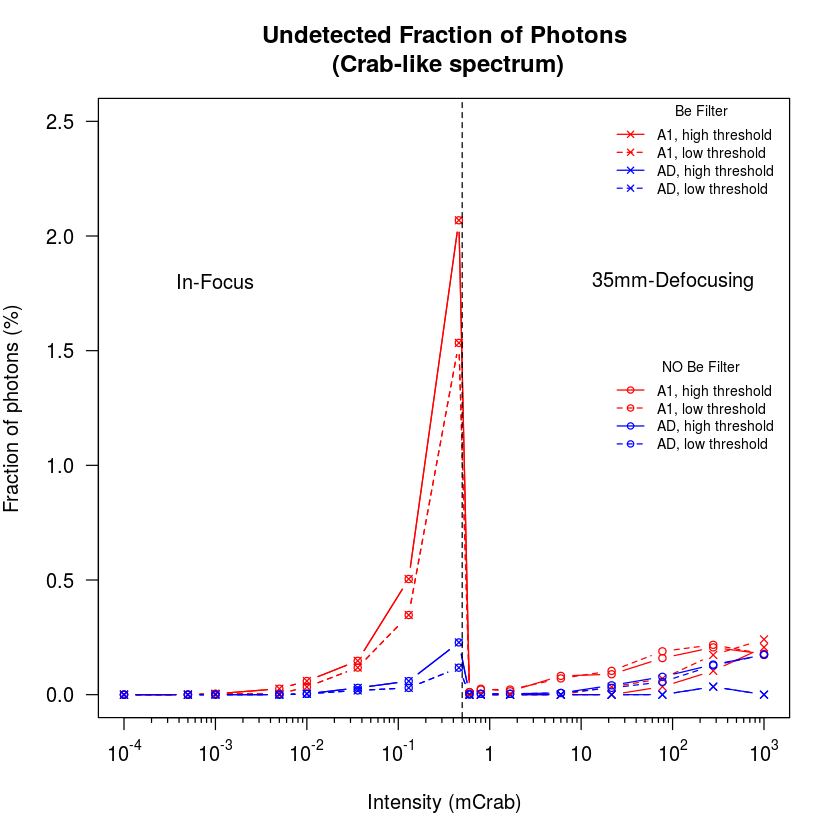

In [35]:
#par(mfrow=c(1,2))
drawLogPlotBox(xlimits=c(1E-4,1E3),ylimits=c(0,2.5), logxy="x",xlabel="Intensity (mCrab)", 
               ylabel=expression("Fraction of photons (%)"), naxes=c(T,T,F,F))
title(main="Undetected Fraction of Photons\n (Crab-like spectrum)")
for (ifi in 1:nfilters){
    points(fluxes.mcrab,percent.A1_lt[,ifi],col="red",type = "b",lty=2,pch=legendPch[ifi],cex=0.8) 
    points(fluxes.mcrab,percent.A1_ht[,ifi],col="red",type = "b",lty=1,pch=legendPch[ifi],cex=0.8) 
    points(fluxes.mcrab,percent.AD_lt[,ifi],col="blue",type = "b",lty=2,pch=legendPch[ifi],cex=0.8)
    points(fluxes.mcrab,percent.AD_ht[,ifi],col="blue",type = "b",lty=1,pch=legendPch[ifi],cex=0.8) 

    legend(legendPos[ifi],legend=c("A1, high threshold","A1, low threshold","AD, high threshold","AD, low threshold"), 
           col=c("red","red","blue","blue"), lty=c(1,2,1,2), 
           pch=c(legendPch[ifi],legendPch[ifi],legendPch[ifi],legendPch[ifi]),cex=0.7,bty="n", title=legendTitles[ifi])
    
}
abline(v=0.5, lty=2)
text(x=1E-3,y=1.8,"In-Focus")
text(x=1E2,y=1.8,"35mm-Defocusing")

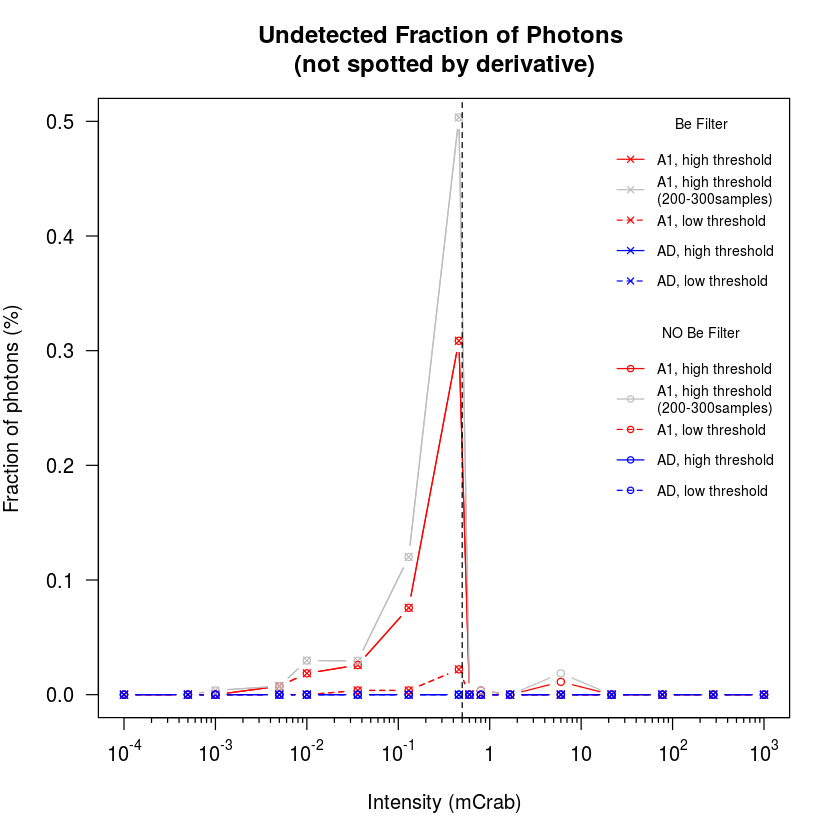

In [36]:
drawLogPlotBox(xlimits=c(1E-4,1E3),ylimits=c(0,0.5), logxy="x",xlabel="Intensity (mCrab)", 
               ylabel=expression("Fraction of photons (%)"), naxes=c(T,T,F,F))
title(main="Undetected Fraction of Photons \n(not spotted by derivative)",cex=0.8)
for (ifi in 1:nfilters){
    points(fluxes.mcrab,percent.BPA1_ht[,ifi],col="red",lty=1,type = "b",pch=legendPch[ifi],cex=0.8)
    points(fluxes.mcrab,percent.BPA1_ht_cnsrv[,ifi],col="grey",lty=1,type = "b",pch=legendPch[ifi],cex=0.8)
    points(fluxes.mcrab,percent.BPA1_lt[,ifi],col="red",lty=2,type = "b",pch=legendPch[ifi],cex=0.8)
    points(fluxes.mcrab,percent.BPAD_ht[,ifi],col="blue",lty=1,type = "b",pch=legendPch[ifi],cex=0.8)
    points(fluxes.mcrab,percent.BPAD_lt[,ifi],col="blue",lty=2,type = "b",pch=legendPch[ifi],cex=0.8)
    legend(legendPos[ifi],legend=c("A1, high threshold","A1, high threshold\n(200-300samples)",
                               "A1, low threshold","AD, high threshold","AD, low threshold"), 
           col=c("red","grey","red","blue","blue"), lty=c(1,1,2,1,2), 
           pch=c(legendPch[ifi],legendPch[ifi],legendPch[ifi],legendPch[ifi],legendPch[ifi]),cex=0.7,bty="n",
           title=legendTitles[ifi])
}
abline(v=0.5, lty=2)
text(x=1E-3,y=1.8,"In-Focus")
text(x=1E2,y=1.8,"35mm-Defocusing")
#dev.off()